# MlFlow Experiment Tracking Setup

In [1]:
import mlflow
mlflow.autolog()
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("RestNet50_Freeze_with_2_additional_layers")
mlflow.set_tag("mlflow.runName", "RestNet50_Freeze_with_2_additional_layers_version_2")
mlflow.set_experiment_tag

<function mlflow.tracking.fluent.set_experiment_tag(key: str, value: Any) -> None>

# Imports

In [2]:
import os
import cv2
import sys
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, Subset
#Using Resnet50 for classification
import torchvision.models as models
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

MAIN_DIR = Path("__file__").resolve().parent.parent.parent
CLASSIFICATION_MAPPING_DIR = os.path.join(MAIN_DIR, "classification_mapping") 
if CLASSIFICATION_MAPPING_DIR not in sys.path:
    sys.path.insert(0, CLASSIFICATION_MAPPING_DIR)
from classification_mapping import CLASSIFICATION_MAPPING

DATA_DIR = os.path.join(MAIN_DIR, 'data')
TRANSLATED_DATA_DIR = os.path.join(MAIN_DIR, 'data_translated_ResNet50')

2025/06/27 11:22:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Loading Dataset

In [4]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [5]:
# Function to transform images to 224x224 for ResNet with normalization based on
# original model image normalization settings
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [6]:
def transformed_image(image_path:str) -> torch.tensor:
    image = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    image_tensor = transform(img_pil)
    return image_tensor

In [7]:
data, labels = [], []

# Reconverting the image to view in data_translated
mean = torch.tensor(mean).view(3, 1, 1)
std = torch.tensor(std).view(3, 1, 1)

for dir_ in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, dir_)
    translated_path = os.path.join(TRANSLATED_DATA_DIR, dir_)
    if not os.path.exists(translated_path): os.makedirs(translated_path)

    for img in os.listdir(path):
        # Load and transform the image
        image_tensor = transformed_image(os.path.join(path, img))
        data.append(image_tensor)
        labels.append(dir_)

        # Convert back to PIL image, unnormalize, and save
        unnormalized = image_tensor * std + mean
        unnormalized = unnormalized.clamp(0, 1)
        
        image_pil = to_pil_image(unnormalized)
        image_translated_path = os.path.join(translated_path, img)
        image_pil.save(image_translated_path)

In [8]:
print(len(data))

178


In [9]:
class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.tensor([CLASSIFICATION_MAPPING[label] for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [10]:
dataset = SignDataset(data, labels)
len(dataset)

178

In [11]:
labels = dataset.labels.numpy()  # your label tensor to numpy array
indices = np.arange(len(dataset))  # indices of all samples

train_indices, val_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

In [12]:
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
train_dataloader = DataLoader(dataset, batch_size = 16, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 16, shuffle = True)

In [13]:
for data, label in train_dataloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([16, 3, 224, 224])
torch.Size([16])


# Loading Pre-trained Model from Pytorch

In [14]:
def create_model():
    # Load ResNet50 with pretrained weights
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    num_classes = 4

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final fully connected layer (model.fc)
    in_features = model.fc.in_features
    
    # Replace the fc layer with a custom sequence of layers
    model.fc = nn.Sequential(
        nn.Linear(in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes)
    )

    # Unfreeze only the new fc layer
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

In [15]:
model = create_model()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# Add checkpoint to model
from torch.utils.checkpoint import checkpoint_sequential
class ResNet50Checkpointed(nn.Module):
    # watch out if segment size is greater than the smaller layers inside a layer => error
    def __init__(self, model, num_segments=4):  # You can tune this
        super().__init__()
        super().__init__()

        # Stem: conv1 → bn1 → relu → maxpool
        self.stem = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool
        )

        # Residual blocks (for checkpointing)
        self.blocks = nn.Sequential(
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        )

        self.num_segments = num_segments

        # Pooling and classification head
        self.avgpool = model.avgpool
        self.fc = model.fc  # Already modified with correct num_classes

    def forward(self, x):
        x = self.stem(x)
        x = checkpoint_sequential(self.blocks, self.num_segments, x, use_reentrant=False)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [35]:
model = torch.compile(ResNet50Checkpointed(model = create_model()).to(DEVICE))
model # won't say which part is checkpointed

OptimizedModule(
  (_orig_mod): ResNet50Checkpointed(
    (stem): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 3)

# Model training

In [20]:
num_epochs = 100
train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], [] 
train_accuracy_obj = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
validation_accuracy_obj = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)

In [21]:
for epoch in range(num_epochs):
    model.train() #setting model mode .train or .eval
    running_loss = 0.0
    train_accuracy_obj.reset()

    # its not acutally each image here but a batch of images instead (batch size = 16 so 16 images)
    for image_batch, label_batch in tqdm(train_dataloader, desc = "Training loop"):
        images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images) # logits output
        # logits output can work directly with labels
        loss = criterion(outputs, labels)
        # logits output can work directly with labels
        # Accuracy work by identifying the dimensions between outputs and labels
        # If same dimension -> labels to labels. If diff dimensions -> Logits to Labels
        train_accuracy_obj.update(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)
    scheduler.step(train_loss)
    train_acc = train_accuracy_obj.compute().item()
    train_accuracy.append(train_acc)

    #Validation phase
    model.eval()
    running_loss = 0.0
    validation_accuracy_obj.reset()
    with torch.no_grad():
        for image_batch, label_batch in tqdm(val_dataloader, desc = "Validation loop"):
            images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            validation_accuracy_obj.update(outputs, labels)
    val_loss = running_loss / len(val_dataloader.dataset)
    val_acc = validation_accuracy_obj.compute().item()
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)
    

    print("Epoch %d out of %s - Train loss: %s , Validation loss: %s , Train accuracy: %s , Validation accuracy: %s " % (epoch + 1, 
                                                                                                                         num_epochs, 
                                                                                                                         train_loss, 
                                                                                                                         val_loss,
                                                                                                                         train_acc,
                                                                                                                         val_acc))

Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 out of 100 - Train loss: 1.357831427220548 , Validation loss: 1.1937165922588773 , Train accuracy: 0.2945089638233185 , Validation accuracy: 0.4318181872367859 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 out of 100 - Train loss: 1.2146921238202728 , Validation loss: 1.0079319212171767 , Train accuracy: 0.4213332533836365 , Validation accuracy: 0.5844155550003052 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 out of 100 - Train loss: 0.9916028561217062 , Validation loss: 0.7016721102926466 , Train accuracy: 0.556644082069397 , Validation accuracy: 0.75 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 out of 100 - Train loss: 0.7274770093767831 , Validation loss: 0.4610840214623345 , Train accuracy: 0.7043712139129639 , Validation accuracy: 0.8214285373687744 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 out of 100 - Train loss: 0.5065616355853134 , Validation loss: 0.27531422509087455 , Train accuracy: 0.8445924520492554 , Validation accuracy: 0.9642857313156128 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 out of 100 - Train loss: 0.4747684410448824 , Validation loss: 0.19055668512980142 , Train accuracy: 0.8198421597480774 , Validation accuracy: 0.9642857313156128 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 out of 100 - Train loss: 0.3280236647370156 , Validation loss: 0.13876961006058586 , Train accuracy: 0.9056816101074219 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 out of 100 - Train loss: 0.37234021639556025 , Validation loss: 0.11253350641992357 , Train accuracy: 0.8784379959106445 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 out of 100 - Train loss: 0.2865937506214956 , Validation loss: 0.08587210294273165 , Train accuracy: 0.9334594011306763 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 out of 100 - Train loss: 0.22283312778794365 , Validation loss: 0.078613157901499 , Train accuracy: 0.960123598575592 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 out of 100 - Train loss: 0.25646047980597847 , Validation loss: 0.10421287351184422 , Train accuracy: 0.9123702645301819 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 out of 100 - Train loss: 0.1662278054805284 , Validation loss: 0.08816436429818471 , Train accuracy: 0.9749220609664917 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 out of 100 - Train loss: 0.14609111041835185 , Validation loss: 0.04717692815595203 , Train accuracy: 0.9695676565170288 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 out of 100 - Train loss: 0.11650991272390558 , Validation loss: 0.04777768668201235 , Train accuracy: 0.9816787838935852 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 out of 100 - Train loss: 0.08270232245493471 , Validation loss: 0.018093239929940965 , Train accuracy: 0.9862987995147705 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16 out of 100 - Train loss: 0.05273483170384771 , Validation loss: 0.010389247340046696 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 out of 100 - Train loss: 0.07207645526093044 , Validation loss: 0.012191055342555046 , Train accuracy: 0.9882478713989258 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 out of 100 - Train loss: 0.07600919617695755 , Validation loss: 0.01461840607225895 , Train accuracy: 0.9838092923164368 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 out of 100 - Train loss: 0.05328217475266939 , Validation loss: 0.013334040426545672 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 out of 100 - Train loss: 0.04385717690325855 , Validation loss: 0.01218567198763291 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21 out of 100 - Train loss: 0.05588647321368871 , Validation loss: 0.008055439348229103 , Train accuracy: 0.9769617915153503 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22 out of 100 - Train loss: 0.06530549896232198 , Validation loss: 0.00916190610991584 , Train accuracy: 0.9883385896682739 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23 out of 100 - Train loss: 0.06342145432247205 , Validation loss: 0.008627261035144329 , Train accuracy: 0.9855769276618958 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24 out of 100 - Train loss: 0.06052375183011709 , Validation loss: 0.012774688398672475 , Train accuracy: 0.9862987995147705 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25 out of 100 - Train loss: 0.052649370949254946 , Validation loss: 0.008006945562859377 , Train accuracy: 0.9836215972900391 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26 out of 100 - Train loss: 0.06833412104778075 , Validation loss: 0.006146860722866323 , Train accuracy: 0.9904752969741821 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27 out of 100 - Train loss: 0.05564483531405417 , Validation loss: 0.009123434260901477 , Train accuracy: 0.9885262250900269 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28 out of 100 - Train loss: 0.06324786743086376 , Validation loss: 0.006206130660656426 , Train accuracy: 0.9857583045959473 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29 out of 100 - Train loss: 0.023103694567519626 , Validation loss: 0.004755077780120903 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30 out of 100 - Train loss: 0.03528877146270001 , Validation loss: 0.0037041068102957476 , Train accuracy: 0.9883385896682739 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31 out of 100 - Train loss: 0.032687872564524746 , Validation loss: 0.0037240669027798707 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32 out of 100 - Train loss: 0.03178165342365758 , Validation loss: 0.003765681344601843 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33 out of 100 - Train loss: 0.05008844215046154 , Validation loss: 0.006003841964734925 , Train accuracy: 0.9885262250900269 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34 out of 100 - Train loss: 0.07314128298940284 , Validation loss: 0.005781620896110932 , Train accuracy: 0.9905660152435303 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35 out of 100 - Train loss: 0.05743513432111633 , Validation loss: 0.003859753203060892 , Train accuracy: 0.9904752969741821 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36 out of 100 - Train loss: 0.03343556046988187 , Validation loss: 0.006520190690126684 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37 out of 100 - Train loss: 0.0697378528335791 , Validation loss: 0.004749155499868923 , Train accuracy: 0.9817695021629333 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38 out of 100 - Train loss: 0.04824289930670449 , Validation loss: 0.00438530132588413 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39 out of 100 - Train loss: 0.03753029429510738 , Validation loss: 0.004109076793409056 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40 out of 100 - Train loss: 0.07143547226873677 , Validation loss: 0.006860845230726732 , Train accuracy: 0.9814910888671875 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41 out of 100 - Train loss: 0.03803166646635934 , Validation loss: 0.008580835225681463 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42 out of 100 - Train loss: 0.04727463173062614 , Validation loss: 0.00552293389207787 , Train accuracy: 0.9883385896682739 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43 out of 100 - Train loss: 0.037996939519483054 , Validation loss: 0.003758939371133844 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44 out of 100 - Train loss: 0.0733190117759651 , Validation loss: 0.003943806824584802 , Train accuracy: 0.9790016412734985 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45 out of 100 - Train loss: 0.025031273975298647 , Validation loss: 0.004241822235700157 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46 out of 100 - Train loss: 0.046777039347739705 , Validation loss: 0.004799427568084664 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47 out of 100 - Train loss: 0.051227134600114285 , Validation loss: 0.003641139690039886 , Train accuracy: 0.9883385896682739 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48 out of 100 - Train loss: 0.03819449120358135 , Validation loss: 0.008290392320810093 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49 out of 100 - Train loss: 0.04319092175096608 , Validation loss: 0.005612940268798007 , Train accuracy: 0.9838092923164368 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50 out of 100 - Train loss: 0.05260111240858442 , Validation loss: 0.00472813109970755 , Train accuracy: 0.9861111044883728 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51 out of 100 - Train loss: 0.03688672511430269 , Validation loss: 0.004737349227070808 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52 out of 100 - Train loss: 0.04798504048853778 , Validation loss: 0.003323152881219155 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53 out of 100 - Train loss: 0.034221913456247095 , Validation loss: 0.0045228200033307076 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54 out of 100 - Train loss: 0.03849395042222537 , Validation loss: 0.004076391691341996 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55 out of 100 - Train loss: 0.03765456625417377 , Validation loss: 0.00716904623226987 , Train accuracy: 0.9864864945411682 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56 out of 100 - Train loss: 0.04820179198397679 , Validation loss: 0.008715776312682364 , Train accuracy: 0.9905660152435303 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57 out of 100 - Train loss: 0.04525081612420886 , Validation loss: 0.005527397824658288 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58 out of 100 - Train loss: 0.052593788990143976 , Validation loss: 0.006995016062218282 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59 out of 100 - Train loss: 0.05218336567952392 , Validation loss: 0.0067848510419329005 , Train accuracy: 0.9746373891830444 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60 out of 100 - Train loss: 0.02988842682222302 , Validation loss: 0.003979250840428803 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61 out of 100 - Train loss: 0.05239911829487661 , Validation loss: 0.0038972661002642578 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62 out of 100 - Train loss: 0.04966550123658073 , Validation loss: 0.004252407673953308 , Train accuracy: 0.9904752969741821 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63 out of 100 - Train loss: 0.07990489665711864 , Validation loss: 0.007865849727143845 , Train accuracy: 0.9904752969741821 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64 out of 100 - Train loss: 0.024732406303453983 , Validation loss: 0.004922160697687004 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65 out of 100 - Train loss: 0.06167066750231753 , Validation loss: 0.00780468149524596 , Train accuracy: 0.9858490228652954 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66 out of 100 - Train loss: 0.05338732363509663 , Validation loss: 0.004178118762663669 , Train accuracy: 0.9885262250900269 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67 out of 100 - Train loss: 0.038848917303460365 , Validation loss: 0.003721845569089055 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68 out of 100 - Train loss: 0.040175894756665394 , Validation loss: 0.004723103510008918 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69 out of 100 - Train loss: 0.06619774558570947 , Validation loss: 0.00523216768892275 , Train accuracy: 0.9837185740470886 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70 out of 100 - Train loss: 0.03345190980628635 , Validation loss: 0.0038973896039856803 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71 out of 100 - Train loss: 0.024962068524923216 , Validation loss: 0.0033314232455773484 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72 out of 100 - Train loss: 0.053209083133868955 , Validation loss: 0.00551194766174174 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73 out of 100 - Train loss: 0.06821697506676899 , Validation loss: 0.0068365311017259955 , Train accuracy: 0.9813941121101379 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74 out of 100 - Train loss: 0.047451115558656415 , Validation loss: 0.006321261197121607 , Train accuracy: 0.9885262250900269 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75 out of 100 - Train loss: 0.04943936351644859 , Validation loss: 0.00531218006896476 , Train accuracy: 0.9883385896682739 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76 out of 100 - Train loss: 0.054140687532974095 , Validation loss: 0.006008027535345819 , Train accuracy: 0.9905660152435303 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77 out of 100 - Train loss: 0.050986235731103446 , Validation loss: 0.0041326142511227066 , Train accuracy: 0.9905660152435303 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78 out of 100 - Train loss: 0.039211025775483486 , Validation loss: 0.004112926518751515 , Train accuracy: 0.9885262250900269 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79 out of 100 - Train loss: 0.06314432591702161 , Validation loss: 0.005643942289882236 , Train accuracy: 0.9789046049118042 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80 out of 100 - Train loss: 0.039504899946826225 , Validation loss: 0.005464687529537413 , Train accuracy: 0.9905660152435303 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81 out of 100 - Train loss: 0.05127004215891442 , Validation loss: 0.007739784299499459 , Train accuracy: 0.9883385896682739 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82 out of 100 - Train loss: 0.04060886708203326 , Validation loss: 0.004836290246910519 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83 out of 100 - Train loss: 0.052790676944711235 , Validation loss: 0.00516491464804858 , Train accuracy: 0.9884355664253235 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84 out of 100 - Train loss: 0.04515211882718494 , Validation loss: 0.003848060254111058 , Train accuracy: 0.9904752969741821 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85 out of 100 - Train loss: 0.056781621712647126 , Validation loss: 0.003987083004580604 , Train accuracy: 0.9770525693893433 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86 out of 100 - Train loss: 0.017144436508500845 , Validation loss: 0.005472023091796372 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87 out of 100 - Train loss: 0.04184058258372746 , Validation loss: 0.0047274325301663745 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88 out of 100 - Train loss: 0.06401705168438761 , Validation loss: 0.004091885121953156 , Train accuracy: 0.9885262250900269 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89 out of 100 - Train loss: 0.04367426598674796 , Validation loss: 0.004496116708550189 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90 out of 100 - Train loss: 0.07393055183164189 , Validation loss: 0.0060077401705914074 , Train accuracy: 0.9695676565170288 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91 out of 100 - Train loss: 0.05174352789527915 , Validation loss: 0.004666794815825092 , Train accuracy: 0.9838092923164368 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92 out of 100 - Train loss: 0.04162984718097729 , Validation loss: 0.004298377368185256 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93 out of 100 - Train loss: 0.0320635356762436 , Validation loss: 0.0037834132607612344 , Train accuracy: 0.9885262250900269 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94 out of 100 - Train loss: 0.0509537531251318 , Validation loss: 0.004260887495345539 , Train accuracy: 0.990384578704834 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95 out of 100 - Train loss: 0.040854263046149454 , Validation loss: 0.004296048285646571 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96 out of 100 - Train loss: 0.05152568422006757 , Validation loss: 0.004383210713664691 , Train accuracy: 0.9790922999382019 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97 out of 100 - Train loss: 0.04096319777577111 , Validation loss: 0.005265294677681393 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98 out of 100 - Train loss: 0.04006838827822985 , Validation loss: 0.0052835664504932035 , Train accuracy: 0.9885262250900269 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99 out of 100 - Train loss: 0.02476246152701003 , Validation loss: 0.0033340269389251866 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100 out of 100 - Train loss: 0.038002484216448966 , Validation loss: 0.005797884504621227 , Train accuracy: 0.9905660152435303 , Validation accuracy: 1.0 


# Visualize

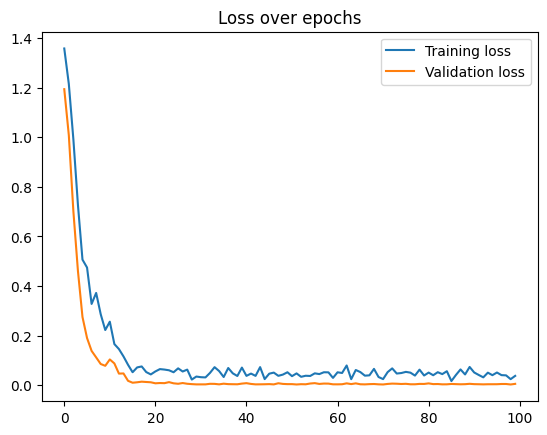

In [22]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

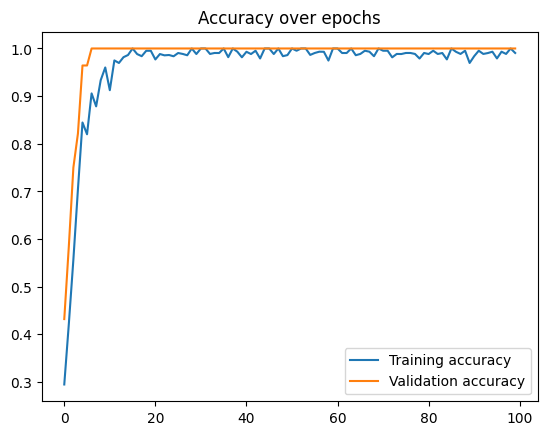

In [23]:
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

# Load MlFlow Registerd Model

model_name = "ResNet50_Freeze"
model_version = "1"
model = mlflow.pytorch.load_model(f"models:/{model_name}/{model_version}")

# Test Model with Seperated Test Data

In [24]:
#TEST_FOLDER_DIR = os.path.join(os.path.dirname(MAIN_DIR), "test_data")
TEST_FOLDER_DIR = os.path.join(MAIN_DIR, "test_data")
test_data, test_labels = [], []

for dir_ in os.listdir(TEST_FOLDER_DIR):
    path = os.path.join(TEST_FOLDER_DIR, dir_)

    for img in os.listdir(path):
        image_tensor = transformed_image(os.path.join(path, img))
        test_data.append(image_tensor)
        test_labels.append(dir_)


In [25]:
test_dataset = SignDataset(test_data, test_labels)
len(test_dataset)
test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset))

for data, label in test_dataloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([35, 3, 224, 224])
torch.Size([35])


In [26]:
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        for image_batch, label_batch in tqdm(test_dataloader, desc = "Validation loop"):
            images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)
            outputs = model(images)
            return outputs, labels

In [27]:
predicted, ground_truth = predict(model, test_dataloader)

accuracy = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
precision = Precision(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
recall = Recall(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
f1score = F1Score(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)

accuracy.update(predicted, ground_truth)
precision.update(predicted, ground_truth)
recall.update(predicted, ground_truth)
f1score.update(predicted, ground_truth)

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
# Compute and print results
print("Accuracy:", accuracy.compute())
print("Precision:", precision.compute())
print("Recall:", recall.compute())
print("F1 Score:", f1score.compute())

Accuracy: tensor(0.8889, device='cuda:0')
Precision: tensor(0.8939, device='cuda:0')
Recall: tensor(0.8889, device='cuda:0')
F1 Score: tensor(0.8791, device='cuda:0')


# Logging with MlFlow

In [29]:
# Log parameters 
mlflow.log_param("optimizer", "Adam")
mlflow.log_param("learning_rate", 0.001)
mlflow.log_param("weight_decay", 0.0001)
mlflow.log_param("loss_function", "CrossEntropyLoss")
mlflow.log_param("epoch", 100)
mlflow.log_param("traing_batch_size", 16)
mlflow.log_param("validation_batch_size", 16)

16

In [30]:
# Log result
mlflow.log_metric("train_loss", train_loss)
mlflow.log_metric("train_accuracy", train_acc)
mlflow.log_metric("validation_loss", val_loss)
mlflow.log_metric("validation_accuracy", val_acc)
mlflow.log_metric("test_accuracy", accuracy.compute())
mlflow.log_metric("test_precision", precision.compute())
mlflow.log_metric("test_recall", recall.compute())
mlflow.log_metric("test_f1", f1score.compute())

In [31]:
# Log dataset
mlflow.log_artifacts(DATA_DIR, artifact_path="dataset")
mlflow.log_artifacts(TEST_FOLDER_DIR, artifact_path="test_dataset")

In [32]:
# Log model
mlflow.pytorch.log_model(artifact_path="ResNet50_Freeze_with_2_additional_layers", pytorch_model=model, registered_model_name="ResNet50_Freeze_with_2_additional_layers")

2025/06/27 11:24:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/27 11:24:52 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.22.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.22.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/27 11:24:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'ResNet50_Freeze_with

In [34]:
print(optimizer.state_dict)

<bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1.0000000000000004e-08
    maximize: False
    weight_decay: 0.0001
)>
